# Kyle Calabro
# DATA 750 - Thesis in Data Science
---

# Notebook Eight:
---
## Deploy transfer learning models with fine-tuning on the original training data, evaluate performance on testing data with grayscale images and contrast stretching.

In [ ]:
!pip install fsspec
!pip install gcsfs

import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings
import re

import time
import glob

from PIL import Image
from skimage import exposure, img_as_float

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, InputLayer, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
#tf.random.set_random_seed(42)

     |████████████████████████████████| 125 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 7.6 MB/s 
     |████████████████████████████████| 160 kB 62.1 MB/s 
     |████████████████████████████████| 271 kB 54.9 MB/s 


In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'quantum-bonus-330300'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'kpc_thesis'

Updated property [core/project].
gs://kpc_thesis/


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.80.172.26:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.80.172.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.80.172.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Utility Functions
---

In [ ]:
# To plot the accuracy of a CNN across epochs

def plot_accuracy(model_hist, model_title):
    plt.plot(model_hist.history["accuracy"])
    plt.plot(model_hist.history["val_accuracy"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "best")
    plt.show();

In [ ]:
# To plot the loss of a CNN across epochs

def plot_loss(model_hist, model_title):
    plt.plot(model_hist.history["loss"])
    plt.plot(model_hist.history["val_loss"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = "best")
    plt.show();

In [ ]:
# To get the predicted labels of a given CNN model
# Params:
    # test_dataset: tf.data dataset containing image tensors and corresponding labels
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(test_dataset, model, encoder):
    y_pred = model.predict(test_dataset)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [ ]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [ ]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names))

In [ ]:
# To load an image from a Google Cloud Storage Bucket and convert to grayscale
# adjusting the contrast by a factor of two

# Params:
  # path: path to the image in the GCS bucket
  # label: the label corresponding to the image given by the path

def load_gs_f2_images(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.grayscale_to_rgb(image)
  image = tf.image.adjust_contrast(image, 2)
  image = tf.cast(image, tf.float32) / 255.0

  return image, label

# Bringing in the Data
----

In [ ]:
regex = re.compile(r"\d+")

In [ ]:
# Generate list of files containing the training images from the bucket
train_files = tf.io.gfile.glob("gs://kpc_thesis/Orig_Train/*.jpeg")

# Get the metadata of the images
train_metadata = pd.read_csv("gs://kpc_thesis/Orig_Train/orig_train_data.csv")
train_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in train_files]
index_list = list(map(int, index_list))

train_labels = [train_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
# Generate list of files containing the test images from the bucket
test_files = tf.io.gfile.glob("gs://kpc_thesis/Orig_Test/*.jpeg")

# Get the metadata of the images
test_metadata = pd.read_csv("gs://kpc_thesis/Orig_Test/orig_test_data.csv")
test_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in test_files]
index_list = list(map(int, index_list))

test_labels = [test_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
print("Number of Training Labels:", len(train_labels))

Number of Training Labels: 1152


In [ ]:
print("Number of Testing Labels:", len(test_labels))

Number of Testing Labels: 288


In [ ]:
# One-hot encoding
encoder = LabelEncoder()

y_train = to_categorical(encoder.fit_transform(train_labels))
y_test = to_categorical(encoder.fit_transform(test_labels))

In [ ]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [ ]:
# Create TF datasets from the images and corresponding labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, y_test))

In [ ]:
train_dataset = (train_dataset.map(load_gs_f2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
train_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [ ]:
test_dataset = (test_dataset.map(load_gs_f2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
test_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [ ]:
# Define the input shape of the image tensors for the network
input_shape_orig = (217, 334, 3)

# VGG-16 Model Deployment with Fine-Tuning
---

### Last two convolutional blocks of the VGG-16 model are unfrozen, weights will change during training

In [ ]:
def create_model():
  vgg = vgg16.VGG16(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg_model = Model(vgg.input, output)

  vgg_model.trainable = True
  set_trainable = False

  for layer in vgg_model.layers:
    if layer.name in ["block5_conv1", "block4_conv1"]:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  
  model = Sequential()
  input_shape = vgg_model.output_shape[1]

  model.add(vgg_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model

with tpu_strategy.scope():
  model = create_model()
  model.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 30720)             14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_1 = time.time()

model_1_hist = model.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_1 = time.time()

Epoch 1/30
36/36 [==============================] - 52s 816ms/step - loss: 2.1142 - accuracy: 0.1606 - val_loss: 1.9408 - val_accuracy: 0.2812
Epoch 2/30
36/36 [==============================] - 29s 804ms/step - loss: 1.9584 - accuracy: 0.2370 - val_loss: 1.7673 - val_accuracy: 0.3958
Epoch 3/30
36/36 [==============================] - 30s 824ms/step - loss: 1.7882 - accuracy: 0.3377 - val_loss: 1.6161 - val_accuracy: 0.4306
Epoch 4/30
36/36 [==============================] - 38s 1s/step - loss: 1.6987 - accuracy: 0.3628 - val_loss: 1.4925 - val_accuracy: 0.4340
Epoch 5/30
36/36 [==============================] - 29s 815ms/step - loss: 1.5818 - accuracy: 0.4297 - val_loss: 1.3906 - val_accuracy: 0.4931
Epoch 6/30
36/36 [==============================] - 29s 811ms/step - loss: 1.4926 - accuracy: 0.4575 - val_loss: 1.2929 - val_accuracy: 0.5347
Epoch 7/30
36/36 [==============================] - 29s 813ms/step - loss: 1.4163 - accuracy: 0.4896 - val_loss: 1.2362 - val_accuracy: 0.5486
Ep

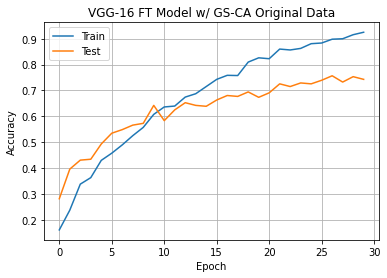

In [ ]:
plot_accuracy(model_1_hist, "VGG-16 FT Model w/ GS-CA Original Data")

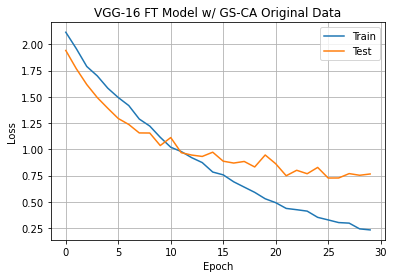

In [ ]:
plot_loss(model_1_hist, "VGG-16 FT Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_1 - start_time_model_1), "\n")

Elapsed Training Time: 1025.5854506492615 seconds 



In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 8s 693ms/step - loss: 0.7649 - accuracy: 0.7431


[0.7649307250976562, 0.7430555820465088]

In [ ]:
y_pred_model_1 = get_predictions(test_dataset, model, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_1, encoder)

              precision    recall  f1-score   support

       Angry       0.70      0.80      0.75        35
        Calm       0.80      0.89      0.84        36
     Disgust       0.76      0.87      0.81        39
        Fear       0.65      0.78      0.70        40
       Happy       0.94      0.47      0.63        36
     Neutral       0.78      0.58      0.67        24
         Sad       0.61      0.53      0.56        38
    Surprise       0.83      0.95      0.88        40

    accuracy                           0.74       288
   macro avg       0.76      0.73      0.73       288
weighted avg       0.75      0.74      0.73       288



In [ ]:
model.save("/content/drive/My Drive/Thesis/RAVDESS/VGG16_FT_GS-CA_Orig_Data_TPU.h5")

# VGG-19 Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  vgg_19 = vgg19.VGG19(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg_19.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg19_model = Model(vgg_19.input, output)

  vgg19_model.trainable = True
  set_trainable = False

  for layer in vgg19_model.layers:
    if layer.name in ["block5_conv1", "block4_conv1"]:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  
  model = Sequential()
  input_shape = vgg19_model.output_shape[1]

  model.add(vgg19_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model

with tpu_strategy.scope():
  model_3 = create_model()
  model_3.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_3.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 30720)             20024384  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               15729152  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_3 = time.time()

model_3_hist = model_3.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_3 = time.time()

Epoch 1/30
36/36 [==============================] - 52s 888ms/step - loss: 2.1448 - accuracy: 0.1510 - val_loss: 1.9725 - val_accuracy: 0.3507
Epoch 2/30
36/36 [==============================] - 33s 921ms/step - loss: 1.9872 - accuracy: 0.2274 - val_loss: 1.8363 - val_accuracy: 0.3924
Epoch 3/30
36/36 [==============================] - 44s 1s/step - loss: 1.8440 - accuracy: 0.3134 - val_loss: 1.7020 - val_accuracy: 0.4167
Epoch 4/30
36/36 [==============================] - 33s 910ms/step - loss: 1.7299 - accuracy: 0.3637 - val_loss: 1.5771 - val_accuracy: 0.4549
Epoch 5/30
36/36 [==============================] - 43s 1s/step - loss: 1.5835 - accuracy: 0.4306 - val_loss: 1.4646 - val_accuracy: 0.4722
Epoch 6/30
36/36 [==============================] - 34s 937ms/step - loss: 1.4821 - accuracy: 0.4609 - val_loss: 1.3535 - val_accuracy: 0.5069
Epoch 7/30
36/36 [==============================] - 33s 911ms/step - loss: 1.3882 - accuracy: 0.4861 - val_loss: 1.2733 - val_accuracy: 0.5139
Epoch

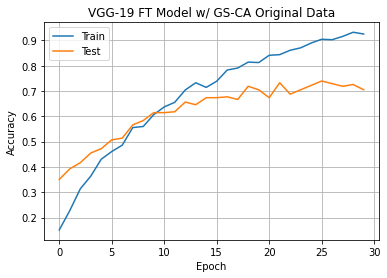

In [ ]:
plot_accuracy(model_3_hist, "VGG-19 FT Model w/ GS-CA Original Data")

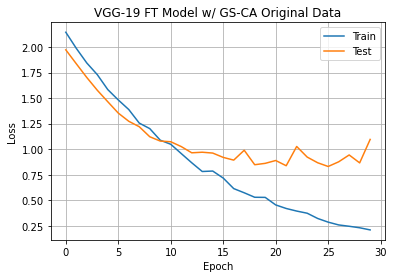

In [ ]:
plot_loss(model_3_hist, "VGG-19 FT Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_3 - start_time_model_3), "\n")

Elapsed Training Time: 1088.0807371139526 seconds 



In [ ]:
model_3.evaluate(test_dataset)

9/9 [==============================] - 8s 699ms/step - loss: 1.0956 - accuracy: 0.7049


[1.0956039428710938, 0.7048611044883728]

In [ ]:
y_pred_model_3 = get_predictions(test_dataset, model_3, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_3, encoder)

              precision    recall  f1-score   support

       Angry       0.46      0.94      0.62        35
        Calm       0.93      0.75      0.83        36
     Disgust       0.92      0.62      0.74        39
        Fear       0.94      0.40      0.56        40
       Happy       0.69      0.61      0.65        36
     Neutral       0.89      0.71      0.79        24
         Sad       0.56      0.71      0.63        38
    Surprise       0.80      0.93      0.86        40

    accuracy                           0.70       288
   macro avg       0.78      0.71      0.71       288
weighted avg       0.78      0.70      0.71       288



In [ ]:
model_3.save("/content/drive/My Drive/Thesis/RAVDESS/VGG19_FT_GS-CA_Orig_Data_TPU.h5")

# InceptionV3 Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  inception = InceptionV3(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = inception.layers[-1].output
  output = Flatten()(output)
  inception_model = Model(inception.input, output)

  inception_model.trainable = True

  layer_num = len(inception_model.layers)
  for layer in inception_model.layers[:279]:
    layer.trainable = False

  for layer in inception_model.layers[279:]:
    layer.trainable = True

  model = Sequential()
  input_shape = inception_model.output_shape[1]

  model.add(inception_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model

In [ ]:
with tpu_strategy.scope():
  model_4 = create_model()
  model_4.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_4.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 92160)             21802784  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               47186432  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_4 = time.time()

model_4_hist = model_4.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_4 = time.time()

Epoch 1/30
36/36 [==============================] - 65s 1s/step - loss: 2.1128 - accuracy: 0.1910 - val_loss: 1.8355 - val_accuracy: 0.3333
Epoch 2/30
36/36 [==============================] - 33s 916ms/step - loss: 1.8312 - accuracy: 0.3151 - val_loss: 1.6982 - val_accuracy: 0.3924
Epoch 3/30
36/36 [==============================] - 32s 904ms/step - loss: 1.6727 - accuracy: 0.3889 - val_loss: 1.5953 - val_accuracy: 0.4132
Epoch 4/30
36/36 [==============================] - 33s 908ms/step - loss: 1.4821 - accuracy: 0.4627 - val_loss: 1.5037 - val_accuracy: 0.4549
Epoch 5/30
36/36 [==============================] - 33s 925ms/step - loss: 1.3748 - accuracy: 0.5226 - val_loss: 1.4427 - val_accuracy: 0.4722
Epoch 6/30
36/36 [==============================] - 32s 905ms/step - loss: 1.2256 - accuracy: 0.5729 - val_loss: 1.3809 - val_accuracy: 0.5069
Epoch 7/30
36/36 [==============================] - 32s 886ms/step - loss: 1.0750 - accuracy: 0.6345 - val_loss: 1.3197 - val_accuracy: 0.5417
Ep

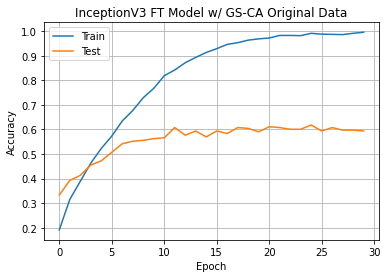

In [ ]:
plot_accuracy(model_4_hist, "InceptionV3 FT Model w/ GS-CA Original Data")

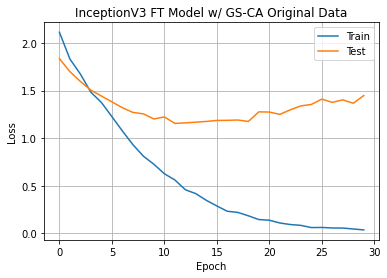

In [ ]:
plot_loss(model_4_hist, "InceptionV3 FT Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_4 - start_time_model_4), "\n")

Elapsed Training Time: 1049.4455721378326 seconds 



In [ ]:
model_4.evaluate(test_dataset)

9/9 [==============================] - 7s 660ms/step - loss: 1.4473 - accuracy: 0.5938


[1.4473176002502441, 0.59375]

In [ ]:
y_pred_model_4 = get_predictions(test_dataset, model_4, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_4, encoder)

              precision    recall  f1-score   support

       Angry       0.55      0.66      0.60        35
        Calm       0.62      0.92      0.74        36
     Disgust       0.64      0.72      0.67        39
        Fear       0.79      0.47      0.59        40
       Happy       0.61      0.47      0.53        36
     Neutral       0.62      0.42      0.50        24
         Sad       0.29      0.32      0.30        38
    Surprise       0.74      0.72      0.73        40

    accuracy                           0.59       288
   macro avg       0.61      0.59      0.58       288
weighted avg       0.61      0.59      0.59       288



In [ ]:
model_4.save("/content/drive/My Drive/Thesis/RAVDESS/InceptionV3_FT_GS-CA_Orig_Data_TPU.h5")

# Xception Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  xception = Xception(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = xception.layers[-1].output
  output = Flatten()(output)
  xception_model = Model(xception.input, output)

  xception_model.trainable = True

  layer_num = len(xception_model.layers)
  for i, layer in enumerate(xception_model.layers):
    if i < 15:
      layer.trainable = False
    else:
      layer.trainable = True

  model = Sequential()
  input_shape = xception_model.output_shape[1]

  model.add(xception_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model      

In [ ]:
with tpu_strategy.scope():
  model_5 = create_model()
  model_5.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_5.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 157696)            20861480  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               80740864  
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_5 = time.time()

model_5_hist = model_5.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_5 = time.time()

Epoch 1/30
36/36 [==============================] - 83s 924ms/step - loss: 2.0817 - accuracy: 0.1771 - val_loss: 1.9815 - val_accuracy: 0.2500
Epoch 2/30
36/36 [==============================] - 33s 932ms/step - loss: 1.8470 - accuracy: 0.2934 - val_loss: 1.8777 - val_accuracy: 0.3160
Epoch 3/30
36/36 [==============================] - 33s 912ms/step - loss: 1.6250 - accuracy: 0.4167 - val_loss: 1.7631 - val_accuracy: 0.3785
Epoch 4/30
36/36 [==============================] - 33s 913ms/step - loss: 1.4013 - accuracy: 0.4974 - val_loss: 1.6809 - val_accuracy: 0.3889
Epoch 5/30
36/36 [==============================] - 36s 1s/step - loss: 1.1441 - accuracy: 0.6189 - val_loss: 1.5460 - val_accuracy: 0.4375
Epoch 6/30
36/36 [==============================] - 62s 2s/step - loss: 0.9009 - accuracy: 0.6892 - val_loss: 1.4652 - val_accuracy: 0.4896
Epoch 7/30
36/36 [==============================] - 34s 956ms/step - loss: 0.6894 - accuracy: 0.7856 - val_loss: 1.4348 - val_accuracy: 0.4757
Epoch

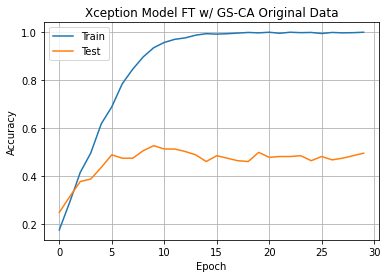

In [ ]:
plot_accuracy(model_5_hist, "Xception Model FT w/ GS-CA Original Data")

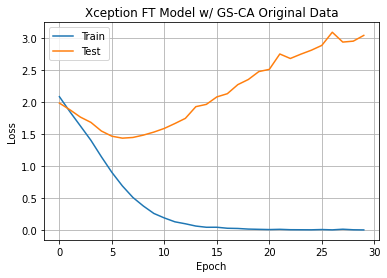

In [ ]:
plot_loss(model_5_hist, "Xception FT Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_5 - start_time_model_5), "\n")

Elapsed Training Time: 1083.523187160492 seconds 



In [ ]:
model_5.evaluate(test_dataset)

9/9 [==============================] - 7s 647ms/step - loss: 3.0379 - accuracy: 0.4965


[3.0378739833831787, 0.4965277910232544]

In [ ]:
y_pred_model_5 = get_predictions(test_dataset, model_5, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_5, encoder)

              precision    recall  f1-score   support

       Angry       0.58      0.54      0.56        35
        Calm       0.51      0.78      0.62        36
     Disgust       0.68      0.49      0.57        39
        Fear       0.43      0.45      0.44        40
       Happy       0.46      0.31      0.37        36
     Neutral       0.38      0.38      0.38        24
         Sad       0.30      0.26      0.28        38
    Surprise       0.59      0.72      0.65        40

    accuracy                           0.50       288
   macro avg       0.49      0.49      0.48       288
weighted avg       0.50      0.50      0.49       288



In [ ]:
model_5.save("/content/drive/My Drive/Thesis/RAVDESS/Xception_FT_GS-CA_Orig_Data_TPU.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# ResNet-50 Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  resnet = ResNet50(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = resnet.layers[-1].output
  output = Flatten()(output)
  resnet_model = Model(resnet.input, output)

  resnet_model.trainable = False

  model = Sequential()
  input_shape = resnet_model.output_shape[1]

  model.add(resnet_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model      

In [ ]:
with tpu_strategy.scope():
  model_6 = create_model()
  model_6.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_6.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 157696)            23587712  
_________________________________________________________________
dense_16 (Dense)             (None, 512)               80740864  
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_6 = time.time()

model_6_hist = model_6.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_6 = time.time()

Epoch 1/30
36/36 [==============================] - 97s 2s/step - loss: 2.2886 - accuracy: 0.1615 - val_loss: 2.0438 - val_accuracy: 0.1389
Epoch 2/30
36/36 [==============================] - 30s 832ms/step - loss: 2.0911 - accuracy: 0.1693 - val_loss: 1.9936 - val_accuracy: 0.2465
Epoch 3/30
36/36 [==============================] - 28s 790ms/step - loss: 2.0627 - accuracy: 0.1892 - val_loss: 2.0166 - val_accuracy: 0.2500
Epoch 4/30
36/36 [==============================] - 29s 795ms/step - loss: 2.0559 - accuracy: 0.1771 - val_loss: 1.9758 - val_accuracy: 0.2292
Epoch 5/30
36/36 [==============================] - 28s 789ms/step - loss: 2.0126 - accuracy: 0.2144 - val_loss: 1.9563 - val_accuracy: 0.2674
Epoch 6/30
36/36 [==============================] - 30s 829ms/step - loss: 1.9870 - accuracy: 0.2005 - val_loss: 1.9513 - val_accuracy: 0.2535
Epoch 7/30
36/36 [==============================] - 33s 923ms/step - loss: 1.9865 - accuracy: 0.2179 - val_loss: 1.9470 - val_accuracy: 0.2847
Ep

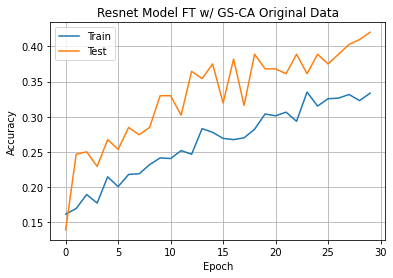

In [ ]:
plot_accuracy(model_6_hist, "Resnet Model FT w/ GS-CA Original Data")

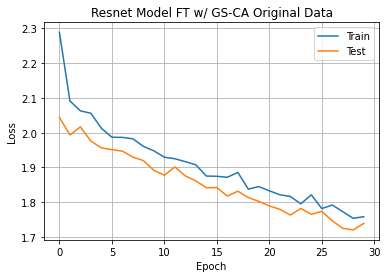

In [ ]:
plot_loss(model_6_hist, "Resnet Model FT w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_6 - start_time_model_6), "\n")

Elapsed Training Time: 1071.7864482402802 seconds 



In [ ]:
model_6.evaluate(test_dataset)

9/9 [==============================] - 8s 696ms/step - loss: 1.7394 - accuracy: 0.4201


[1.7394075393676758, 0.4201388955116272]

In [ ]:
y_pred_model_6 = get_predictions(test_dataset, model_6, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_6, encoder)

              precision    recall  f1-score   support

       Angry       0.35      0.54      0.42        35
        Calm       0.54      0.86      0.67        36
     Disgust       0.63      0.49      0.55        39
        Fear       0.41      0.47      0.44        40
       Happy       0.50      0.03      0.05        36
     Neutral       0.00      0.00      0.00        24
         Sad       0.25      0.03      0.05        38
    Surprise       0.33      0.78      0.46        40

    accuracy                           0.42       288
   macro avg       0.38      0.40      0.33       288
weighted avg       0.39      0.42      0.35       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_6.save("/content/drive/My Drive/Thesis/RAVDESS/Resnet_GS-CA_FT_Orig_Data_TPU.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# AlexNet
---


In [ ]:
def create_model():
  #Instantiation
  AlexNet = Sequential()

  #1st Convolutional Layer
  AlexNet.add(Conv2D(filters = 96, input_shape = input_shape_orig, kernel_size = (11,11), strides = (4, 4), padding = "same"))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))

  #2nd Convolutional Layer
  AlexNet.add(Conv2D(filters = 256, kernel_size = (5, 5), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #3rd Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #4th Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #5th Convolutional Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #Passing it to a Fully Connected layer
  AlexNet.add(Flatten())
  # 1st Fully Connected Layer
  AlexNet.add(Dense(512, input_shape=input_shape_orig))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  AlexNet.add(Dropout(0.4))

  #2nd Fully Connected Layer
  AlexNet.add(Dense(512))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #3rd Fully Connected Layer
  AlexNet.add(Dense(256))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #Output Layer
  AlexNet.add(Dense(8))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('softmax'))

  return AlexNet

In [ ]:
with tpu_strategy.scope():
  AlexNet = create_model()
  AlexNet.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
  
AlexNet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 55, 84, 96)        34944     
_________________________________________________________________
batch_normalization_98 (Batc (None, 55, 84, 96)        384       
_________________________________________________________________
activation_94 (Activation)   (None, 55, 84, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 42, 96)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 28, 42, 256)       614656    
_________________________________________________________________
batch_normalization_99 (Batc (None, 28, 42, 256)       1024      
_________________________________________________________________
activation_95 (Activation)   (None, 28, 42, 256)      

In [ ]:
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = .01, patience = 3, min_lr = 1e-5) 

In [ ]:
start_time_alexnet = time.time()

alexnet_hist = AlexNet.fit(train_dataset, epochs = 30, validation_data = test_dataset, callbacks = [lrr], verbose = 1)

end_time_alexnet = time.time()

Epoch 1/30
36/36 [==============================] - 55s 952ms/step - loss: 2.3098 - accuracy: 0.1545 - val_loss: 235.3840 - val_accuracy: 0.1215
Epoch 2/30
36/36 [==============================] - 34s 938ms/step - loss: 2.0674 - accuracy: 0.2179 - val_loss: 34.1943 - val_accuracy: 0.1215
Epoch 3/30
36/36 [==============================] - 33s 926ms/step - loss: 1.9665 - accuracy: 0.2179 - val_loss: 7.4437 - val_accuracy: 0.1736
Epoch 4/30
36/36 [==============================] - 33s 935ms/step - loss: 1.9317 - accuracy: 0.2578 - val_loss: 2.5766 - val_accuracy: 0.2257
Epoch 5/30
36/36 [==============================] - 32s 903ms/step - loss: 1.8875 - accuracy: 0.2622 - val_loss: 1.9494 - val_accuracy: 0.2014
Epoch 6/30
36/36 [==============================] - 32s 888ms/step - loss: 1.8511 - accuracy: 0.2830 - val_loss: 2.0355 - val_accuracy: 0.1806
Epoch 7/30
36/36 [==============================] - 32s 905ms/step - loss: 1.8306 - accuracy: 0.2891 - val_loss: 2.1672 - val_accuracy: 0.1

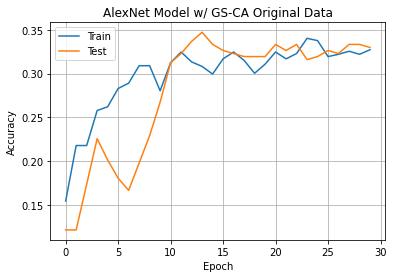

In [ ]:
plot_accuracy(alexnet_hist, "AlexNet Model w/ GS-CA Original Data")

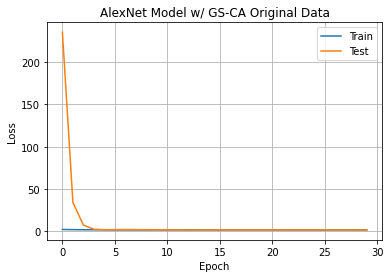

In [ ]:
plot_loss(alexnet_hist, "AlexNet Model w/ GS-CA Original Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_alexnet - start_time_alexnet), "\n")

Elapsed Training Time: 1050.4338648319244 seconds 



In [ ]:
AlexNet.evaluate(test_dataset)

9/9 [==============================] - 7s 682ms/step - loss: 1.8192 - accuracy: 0.3299


[1.819246530532837, 0.3298611044883728]

In [ ]:
y_pred_alexnet = get_predictions(test_dataset, AlexNet, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_alexnet, encoder)

              precision    recall  f1-score   support

       Angry       0.36      0.54      0.43        35
        Calm       0.33      0.58      0.42        36
     Disgust       0.42      0.49      0.45        39
        Fear       0.43      0.07      0.13        40
       Happy       0.50      0.11      0.18        36
     Neutral       0.50      0.04      0.08        24
         Sad       0.15      0.26      0.19        38
    Surprise       0.43      0.45      0.44        40

    accuracy                           0.33       288
   macro avg       0.39      0.32      0.29       288
weighted avg       0.38      0.33      0.30       288



In [ ]:
AlexNet.save("/content/drive/My Drive/Thesis/AlexNet_GS-CA_Orig_Data_TPU.h5")